* <font color="blue"> Dorian QUABOUL 3872944 </font>
* <font color="blue"> Wenshan WU 3874034 </font>

# Practical work 5: edge detection

The goal of this course is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    #plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()
    
def thresholdImage(I,s):
    """ Array*int -> Array """
    return np.where(I<s,0,255)

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n = 2*np.ceil(3*sigma) + 1
    x,y = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
    return  np.exp( (-x**2-y**2)/(2*sigma*sigma))

def subSample2(I):
    #Array -> Array
    return I[::2,::2]


In [2]:
# Chargement des images
lena = np.array(Image.open('img/lena.gif'))
tools = np.array(Image.open('img/tools.gif'))

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [3]:
def SobelDetector(I, s):
    """ Array*double -> Array """
    
    # Filtres Sobel
    Sx = np.array( [ [ 1, 0, -1 ], [ 2, 0, -2 ], [ 1, 0, -1 ] ] )
    Sy = np.array( [ [ 1, 2, 1 ], [ 0, 0, 0 ], [ -1, -2, -1 ] ] )
    
    # Convolution de I avec S
    Gx = convolve2d ( I, Sx, 'same' )
    Gy = convolve2d ( I, Sy, 'same' )
    
    # Calcul du module du gradient de I
    G = np.sqrt ( np.power ( Gx, 2 ) + np.power ( Gy, 2 ) )
    
    # Seuillage du module du gradient de I
    return thresholdImage(G, s)

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and determines the zero crossings of the Laplacian. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [4]:
def LaplacianDetector(I, s):
    """ Array*double -> Array """
    
    # Filtre Laplacian
    L = np.array( [ [ 0, 1, 0 ], [ 1, -4, 1 ], [ 0, 1, 0 ] ] )
    
    # Convolution : I * L
    Gl = convolve2d( I, L, 'same' )
    
    n, m = Gl.shape
    
    M = np.zeros( ( n, m ) )
    
    for i in range( 1, n - 1 ):
        for j in range( 1, m - 1 ):
            voisins = Gl[ i-1 : i+1 , j-1 : j+1 ] # Voisinage 3x3
            if np.max( voisins ) > 0 and np.min( voisins ) < 0 and np.max( voisins ) - np.min( voisins ) > s:
                M[i,j] = 255
                
    return M

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.gif`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

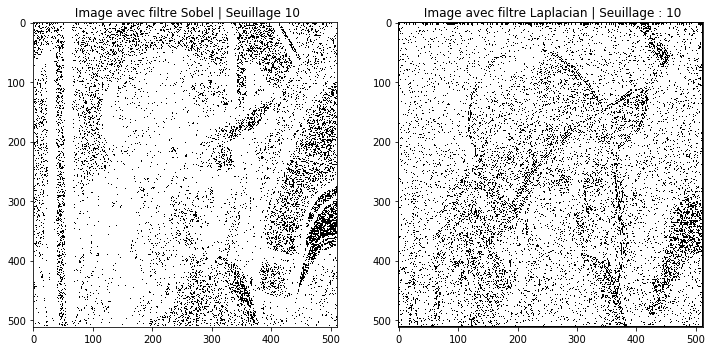

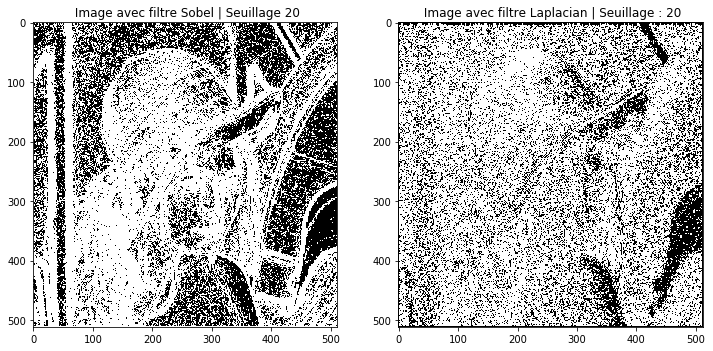

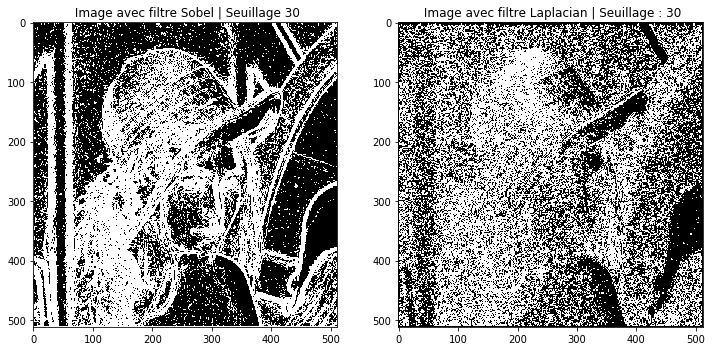

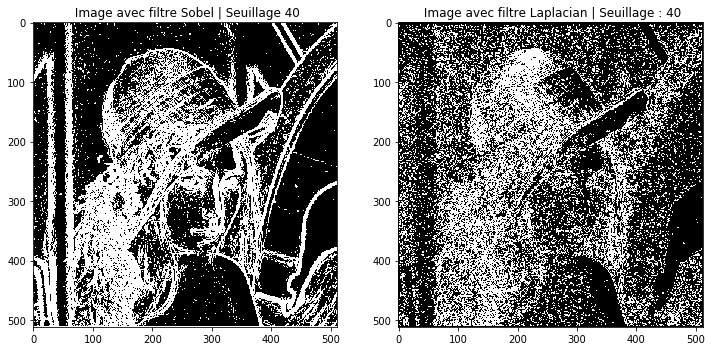

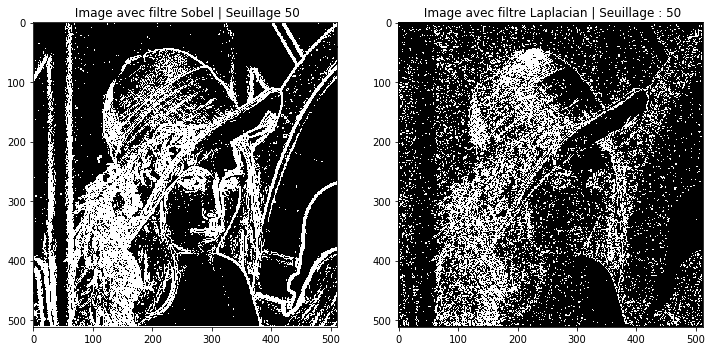

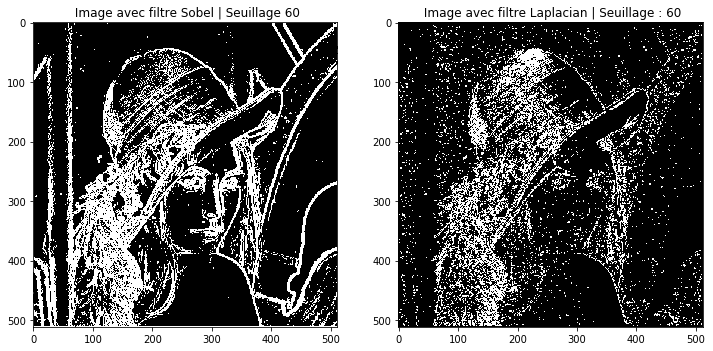

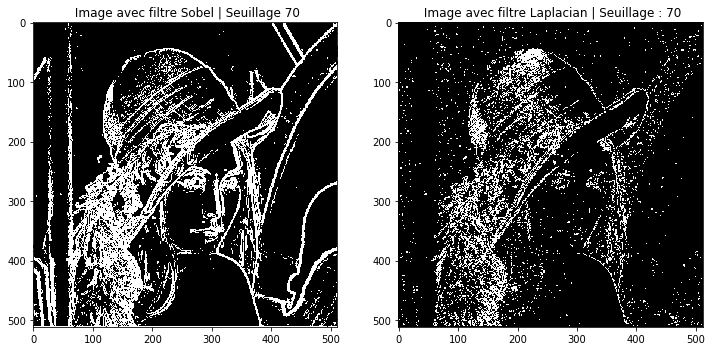

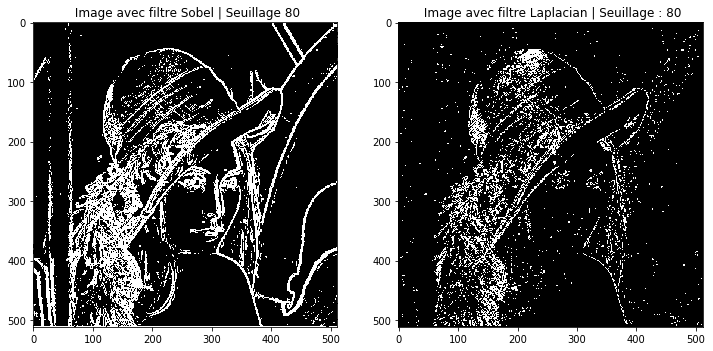

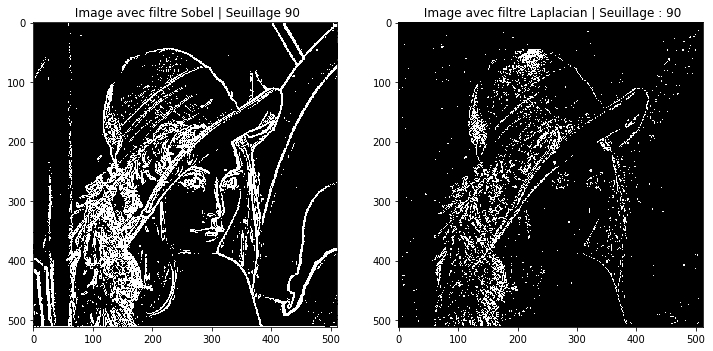

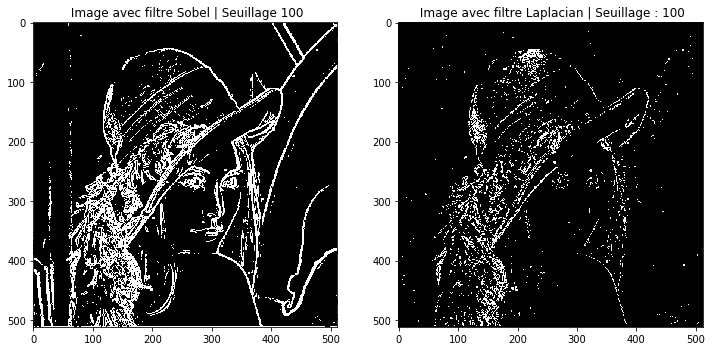

In [5]:
# Test de différents seuillages

for i in range(10,101,10):
    S = SobelDetector( lena, i ) 
    L = LaplacianDetector( lena, i )
    niceDisplay14( [ S, L ], [ " Image avec filtre Sobel | Seuillage "+str(i), " Image avec filtre Laplacian | Seuillage : "+str(i) ] )
    
# On observe que le seuillage approximatif pour les deux détecteurs Sobel et Laplacian est de respectivement 70 et 65 

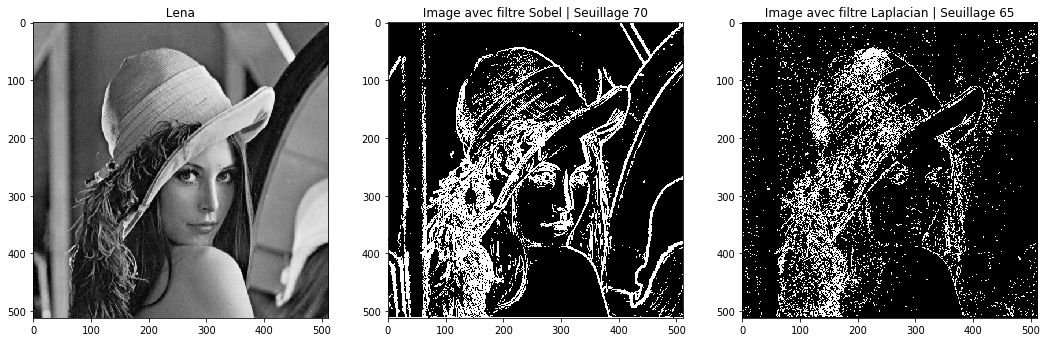

In [6]:
affichages = [ lena, SobelDetector(lena,70), LaplacianDetector(lena,65) ]
niceDisplay14( affichages, [ " Lena ", " Image avec filtre Sobel | Seuillage 70 ", " Image avec filtre Laplacian | Seuillage 65 " ] )


* <font color="red"> En comparant les deux détecteurs de contours, on remarque que les contours détectés par le Sobel sont plus épaix. On observe également la présence de bruits dans l'image lorsqu'on fait passer un détecteur Laplacian. </font>

## Exercice 2: Non maximum suppresion

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.gif`. Verify values according to the different local orientation configurations (use `imshow()` in interactive mode in the nootebook and with the colormap `hot()`).

<IPython.core.display.Javascript object>


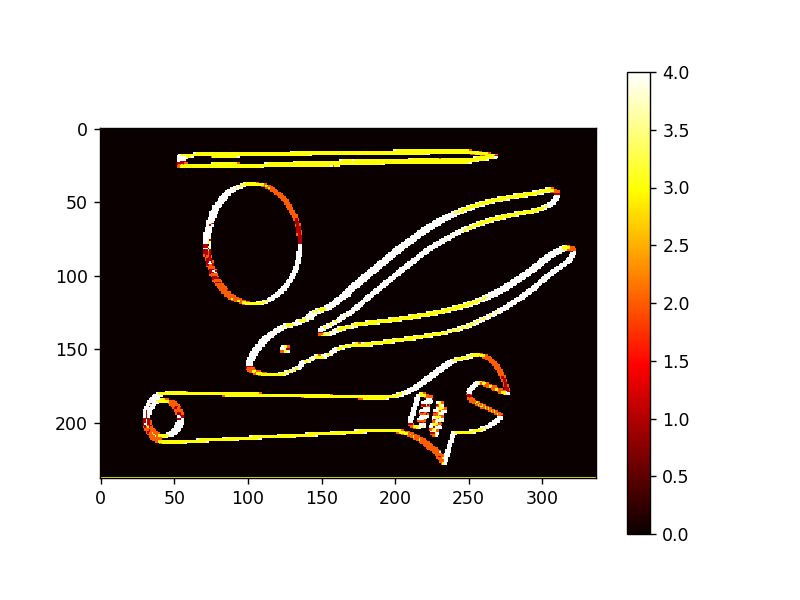

In [7]:
%matplotlib notebook
#### your answer below

Sx = np.array( [ [ 1, 0, -1 ], [ 2, 0, -2 ], [ 1, 0, -1 ] ] )
Sy = np.array( [ [ 1, 2, 1 ], [ 0, 0, 0 ], [ -1, -2, -1 ] ] )

Ix = convolve2d( tools, Sx, 'same' )
Iy = convolve2d( tools, Sy, 'same' )
Ig = np.sqrt ( np.power ( Ix, 2 ) + np.power ( Iy, 2 ) )

Ior = orientation( Ix, Iy, Ig )

plt.imshow(Ior,cmap='hot')
plt.colorbar()

Explain the different values given to a pixel by `orientation()`:

<font color="red"> Les différentes valeurs renseignent sur l'orientation du gradient : </font>

* <font color="red"> 0 aucune orientation car gradient nul </font>
* <font color="red"> 1 pour une orientation 0 </font>
* <font color="red"> 2 pour une orientation $\pi$ / 4 </font>
* <font color="red"> 3 pour une orientation $\pi$ / 2 </font>
* <font color="red"> 4 pour une orientation 3$\pi$ / 4 </font>

<font color="red"> L'orientation est obtenue grâce à la formule suivante :
$\theta = arctan(\frac{Gy}{Gx})$ </font>


2. Write a function `nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning a binary image: pixels set to 1 have should a maxima norm gradient in the direction of the gradient.

In [8]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    
    n, m = Ior.shape
    
    M = Ig.copy()
    
    for i in range( 1, n - 1 ):
        for j in range( 1, m - 1 ):
            if Ior[i][j] == 1:
                voisin1 = Ig[i,j-1]
                voisin2 = Ig[i,j+1]
                if Ig[i][j] >= voisin1 and Ig[i][j] >= voisin2 :
                    pass
                else :
                    M[i,j] = 0
            elif Ior[i][j] == 2:
                voisin1 = Ig[i-1,j-1]
                voisin2 = Ig[i+1,j+1]
                if Ig[i][j] >= voisin1 and Ig[i][j] >= voisin2 :
                    pass
                else :
                    M[i,j] = 0
            elif Ior[i][j] == 3:
                voisin1 = Ig[i-1,j]
                voisin2 = Ig[i+1,j]
                if Ig[i][j] >= voisin1 and Ig[i][j] >= voisin2 :
                    pass
                else :
                    M[i,j] = 0
            elif Ior[i][j] == 4:
                voisin1 = Ig[i-1,j+1]
                voisin2 = Ig[i+1,j-1]
                if Ig[i][j] >= voisin1 and Ig[i][j] >= voisin2 :
                    pass
                else :
                    M[i,j] = 0
                    
            else : 
                M[i,j] = 0
            
                
    return M

<IPython.core.display.Javascript object>


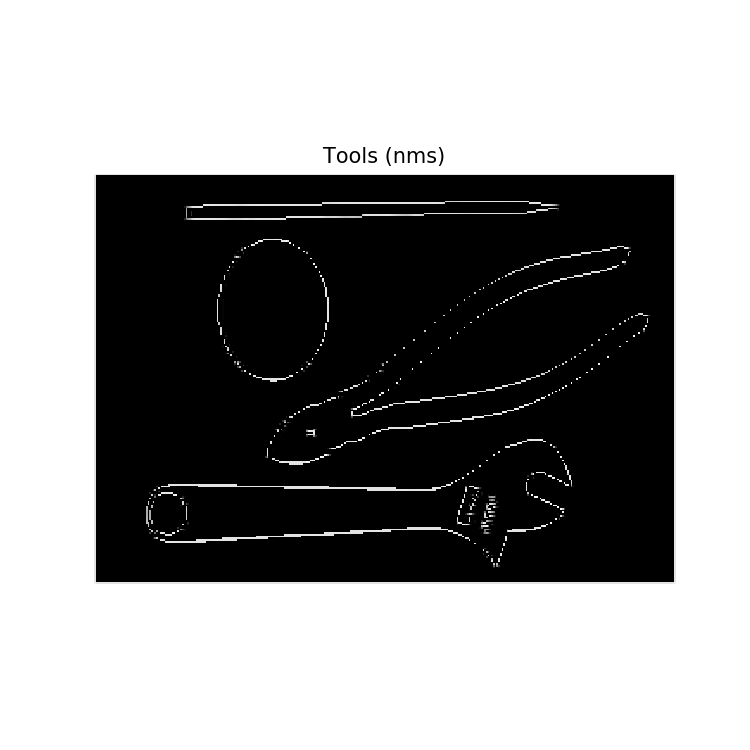

<IPython.core.display.Javascript object>


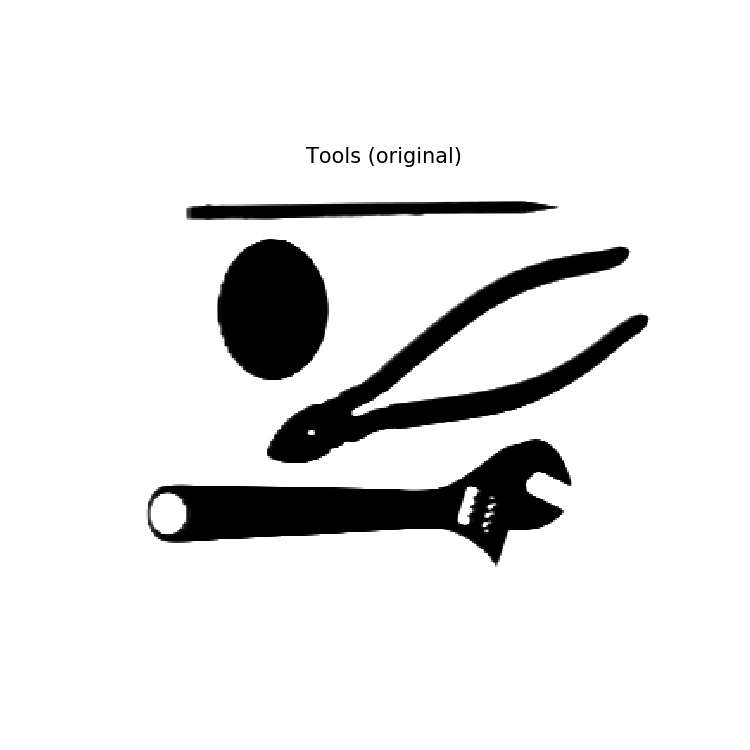

In [9]:
Sx = np.array( [ [ 1, 0, -1 ], [ 2, 0, -2 ], [ 1, 0, -1 ] ] )
Sy = np.array( [ [ 1, 2, 1 ], [ 0, 0, 0 ], [ -1, -2, -1 ] ] )

Ix = convolve2d( tools, Sx, 'same' )
Iy = convolve2d( tools, Sy, 'same' )
Ig = np.sqrt ( np.power ( Ix, 2 ) + np.power ( Iy, 2 ) )

Ior = orientation( Ix, Iy, Ig )

imshow( nms(Ig,Ior), "Tools (nms)" )

imshow( tools, "Tools (original)" )


3. Experiments function `nms()` on images `img/tools.gif` and `img/lena.gif` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


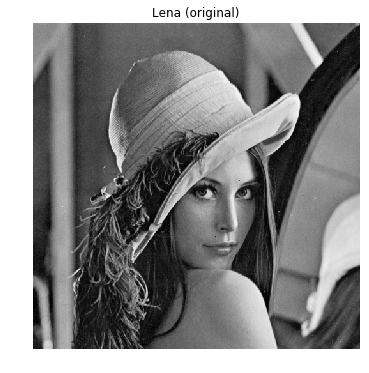

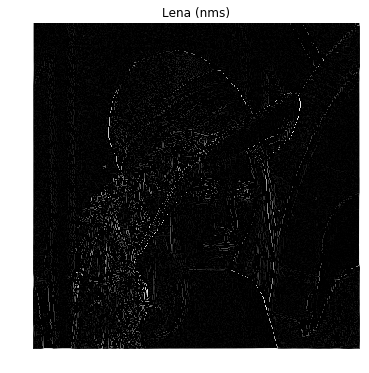

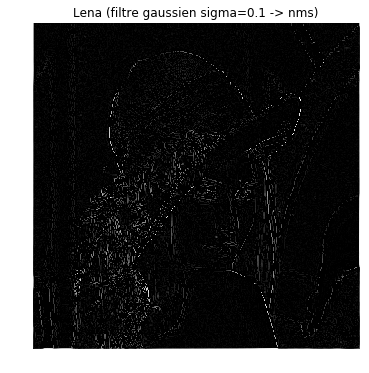

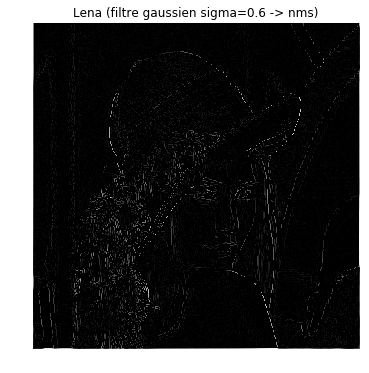

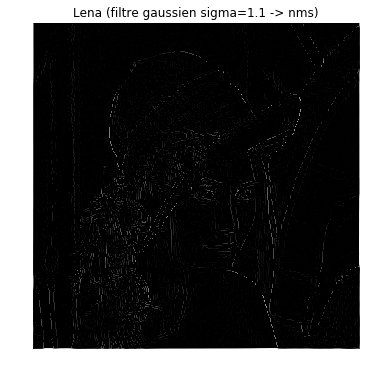

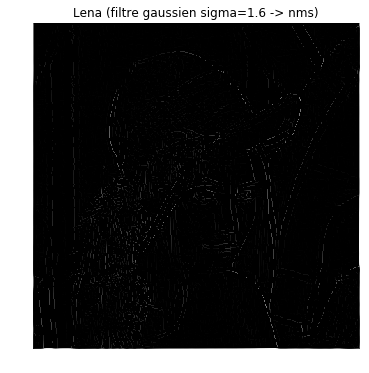

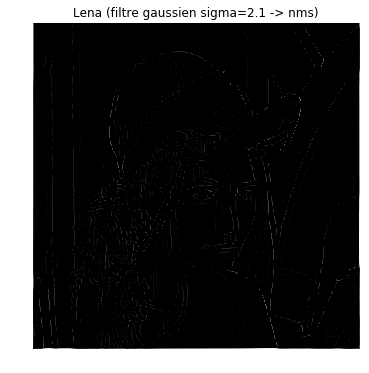

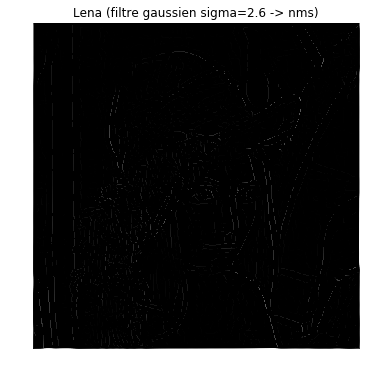

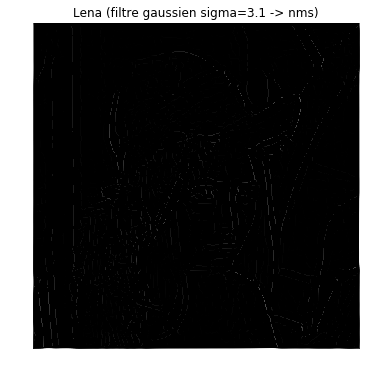

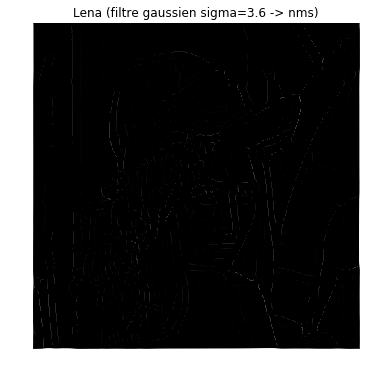

In [10]:
%matplotlib inline
### your answer below

Sx = np.array( [ [ 1, 0, -1 ], [ 2, 0, -2 ], [ 1, 0, -1 ] ] )
Sy = np.array( [ [ 1, 2, 1 ], [ 0, 0, 0 ], [ -1, -2, -1 ] ] )

Ix = convolve2d( lena, Sx, 'same' )
Iy = convolve2d( lena, Sy, 'same' )
Ig = np.sqrt ( np.power ( Ix, 2 ) + np.power ( Iy, 2 ) )

Ior = orientation( Ix, Iy, Ig )

imshow(lena, "Lena (original)")
imshow(nms(Ig,Ior), "Lena (nms)")

for sigma in np.arange(0.1,4,0.5):
    kernel = gaussianKernel(sigma)

    lena_gauss = convolve2d( lena, kernel, 'same' )

    Ix2 = convolve2d( lena_gauss, Sx, 'same' )
    Iy2 = convolve2d( lena_gauss, Sy, 'same' )
    Ig2 = np.sqrt ( np.power ( Ix2, 2 ) + np.power ( Iy2, 2 ) )

    Ior2 = orientation( Ix2, Iy2, Ig2 )

    imshow(nms(Ig2,Ior2), "Lena (filtre gaussien sigma="+str(sigma)+" -> nms)")

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

* <font color="red">$\sigma$ faible, on détecte les contours fins (bruit), bonne localisation. </font>
* <font color="red">$\sigma$ grand, on détecte les structures principales de l'image, mais on perd les détails. </font>


## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.gif`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

In [11]:
# Noyau gaussien
G = gaussianKernel(2)

# Image lissée
Ig = convolve2d( lena, G, 'same' )


2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

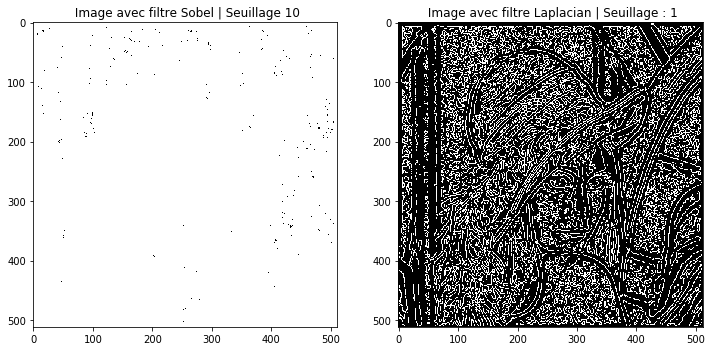

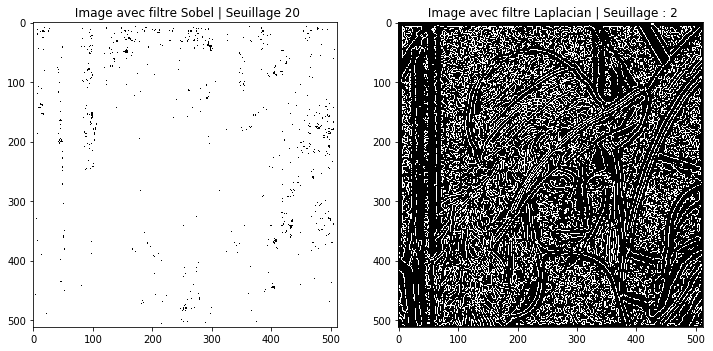

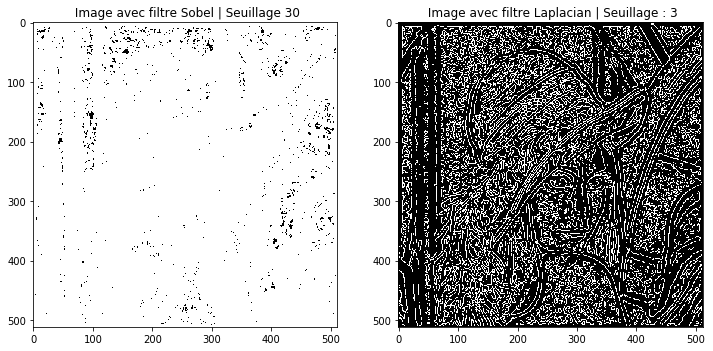

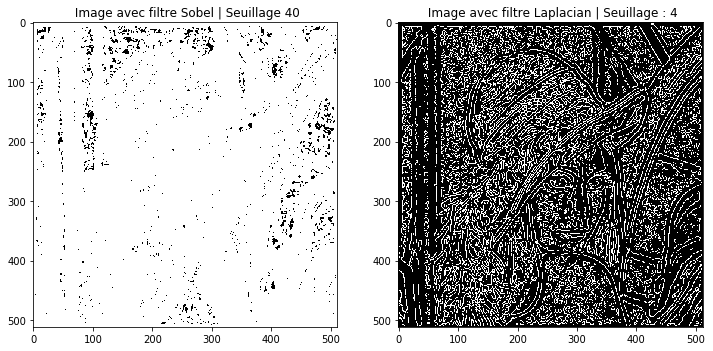

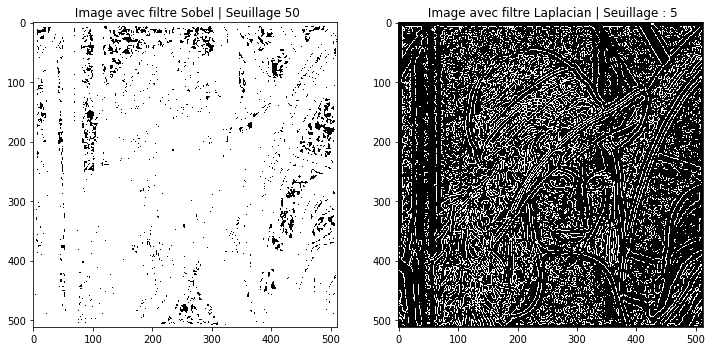

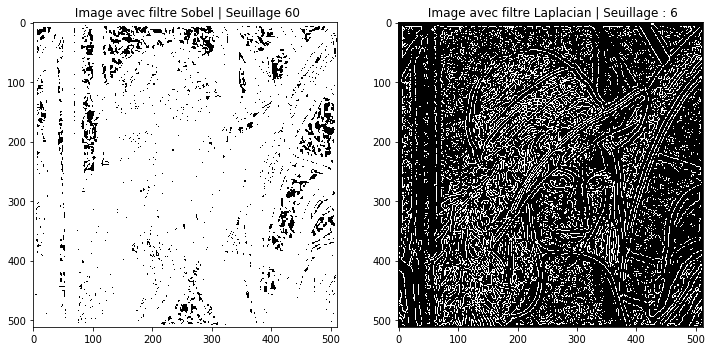

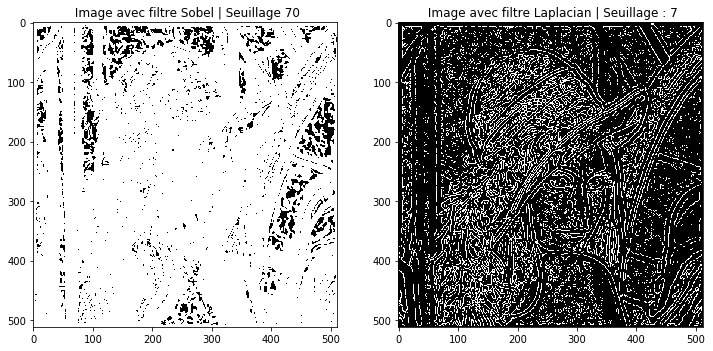

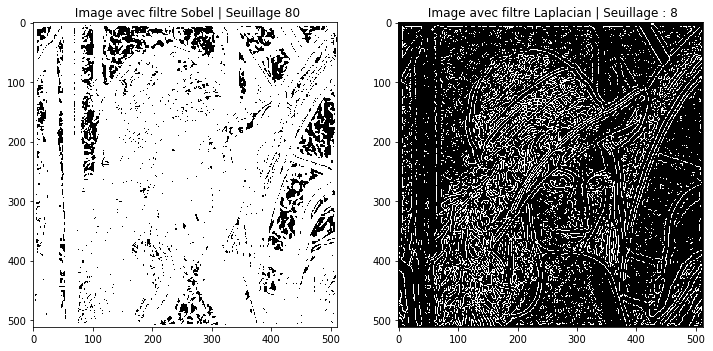

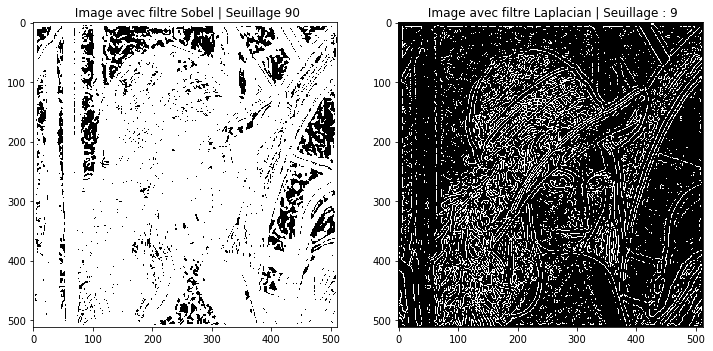

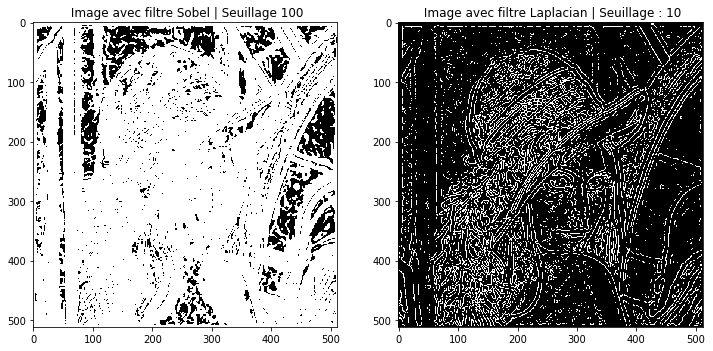

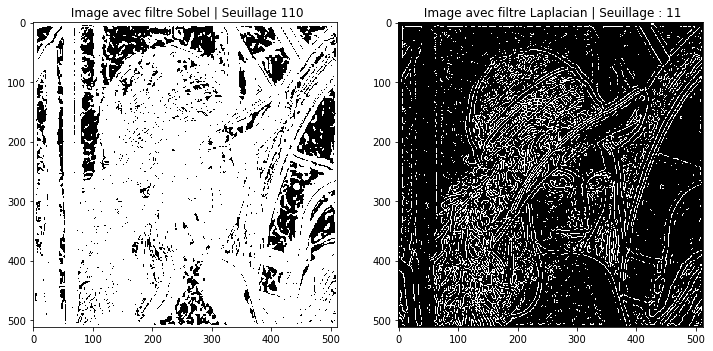

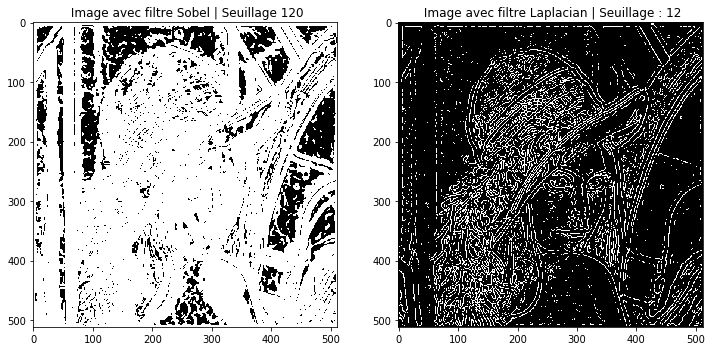

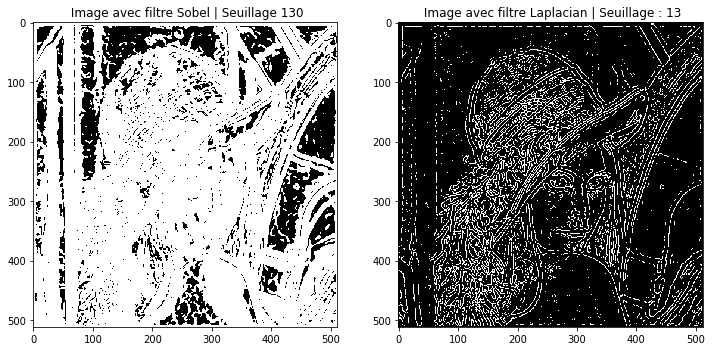

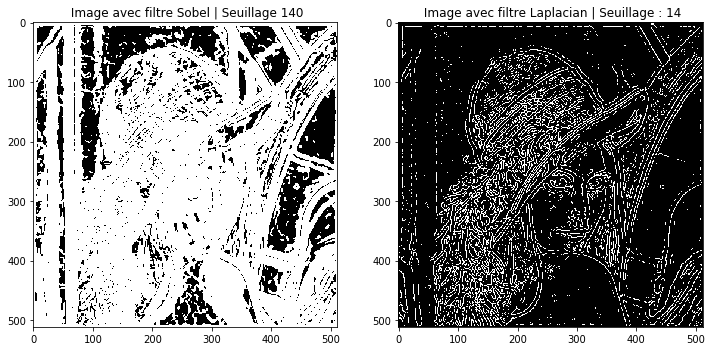

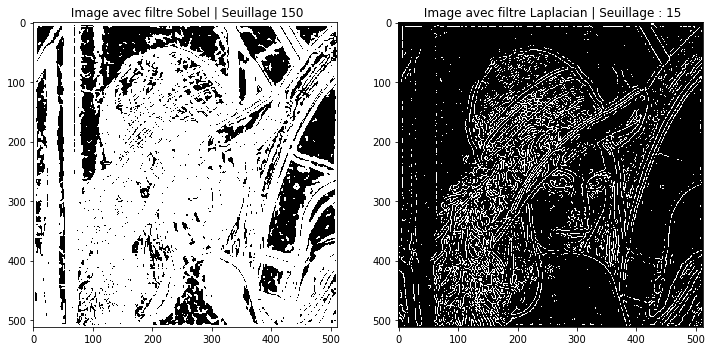

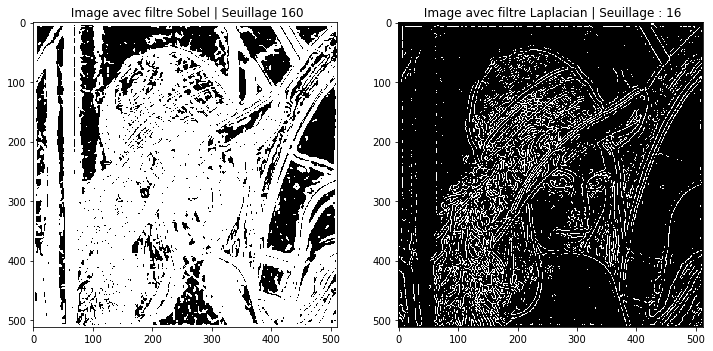

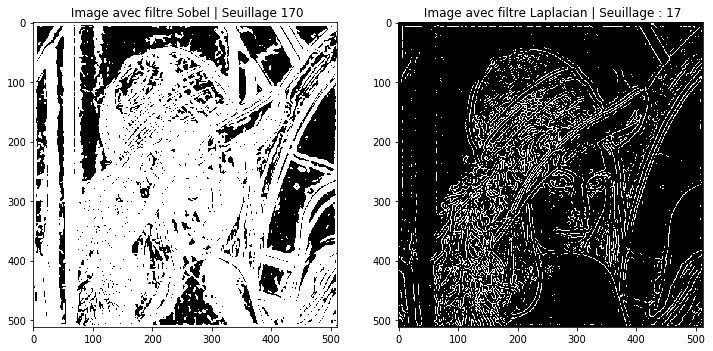

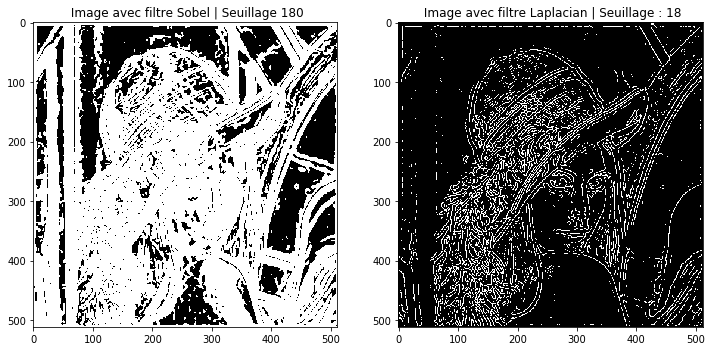

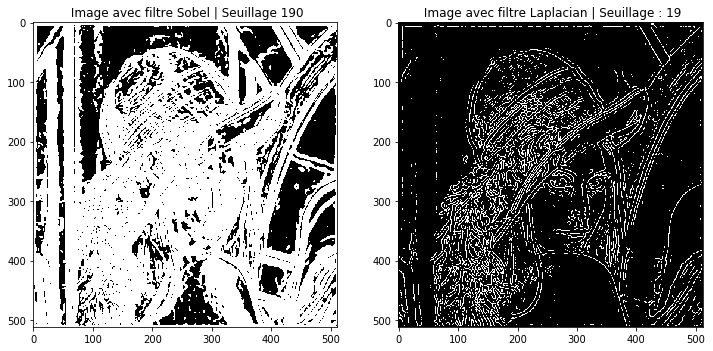

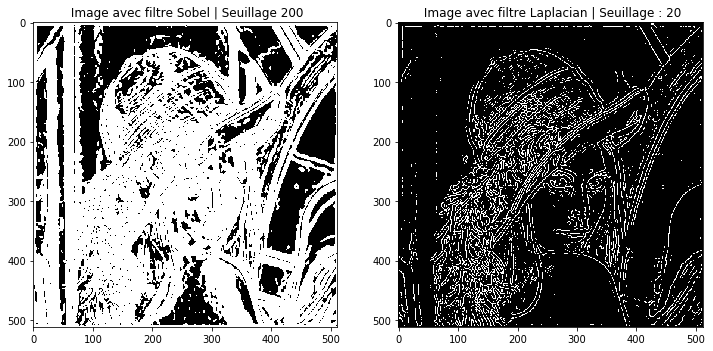

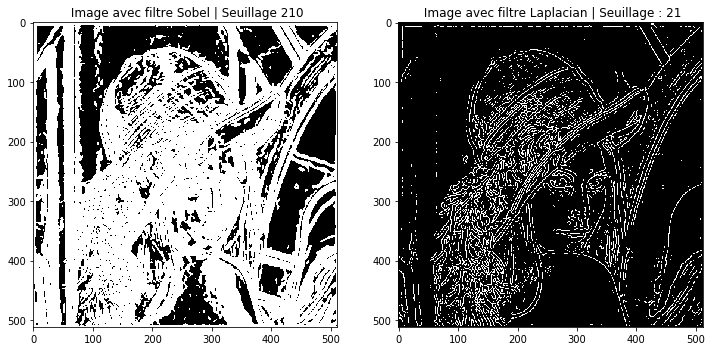

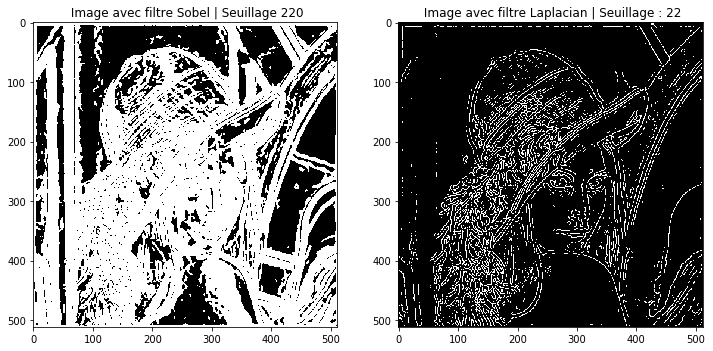

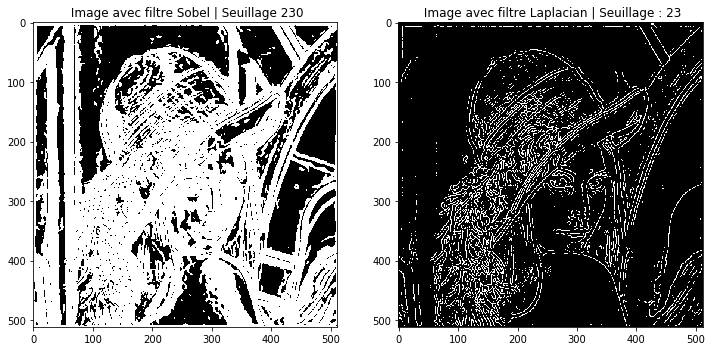

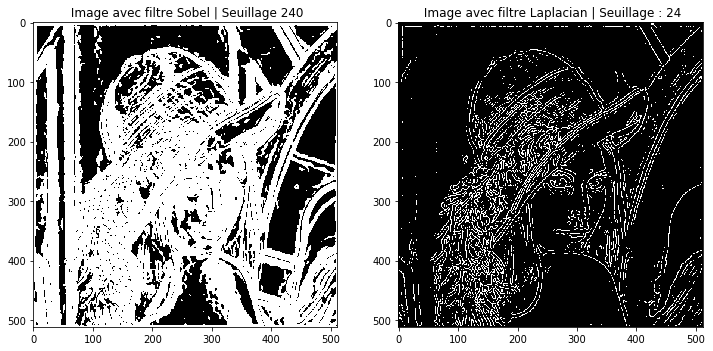

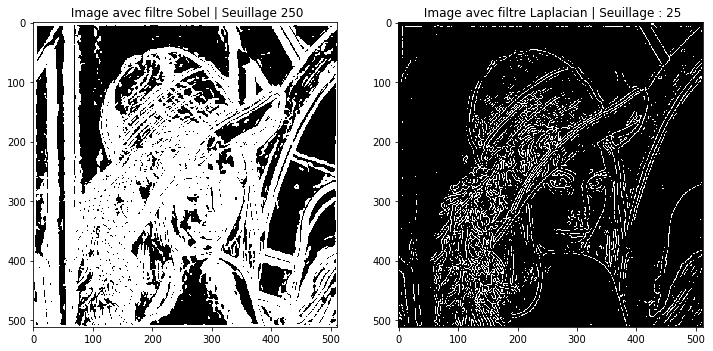

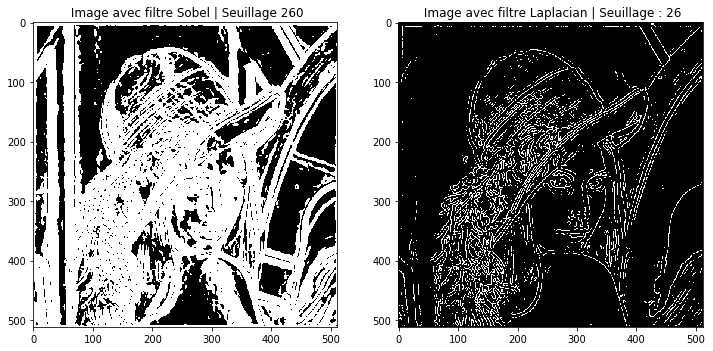

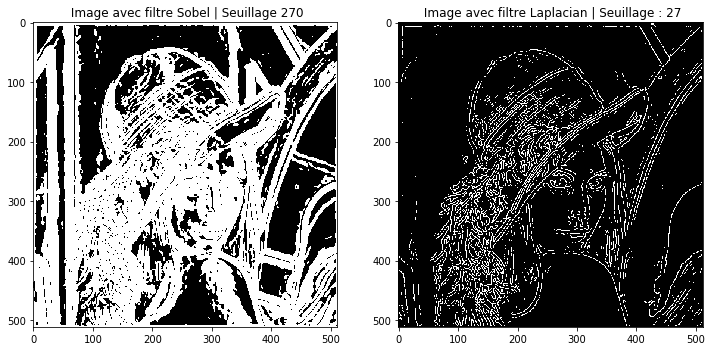

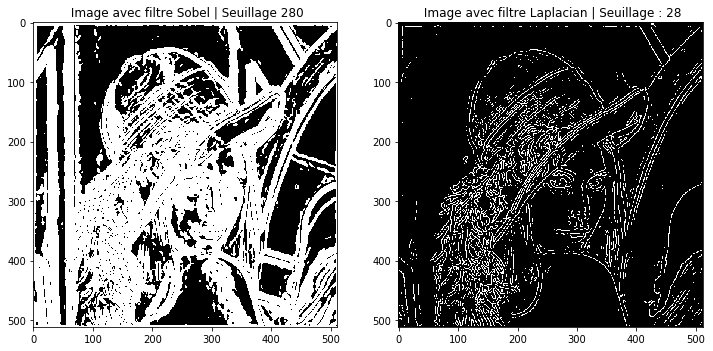

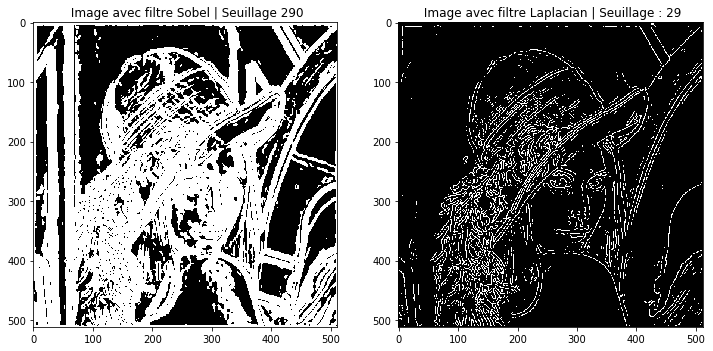

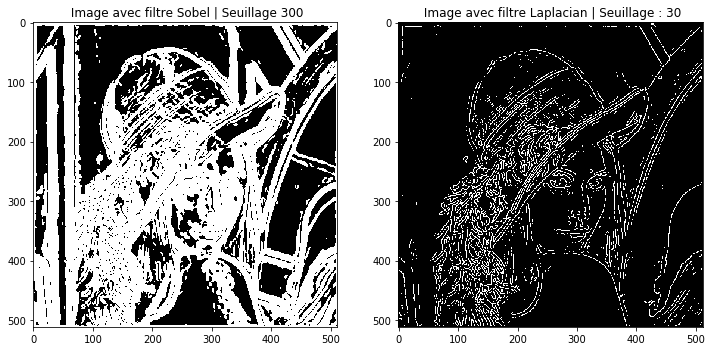

In [15]:
# Test différents seuillages

for i in range(1,31):
    S = SobelDetector( Ig, i*10 ) 
    L = LaplacianDetector( Ig, i )
    niceDisplay14( [ S, L ], [ " Image avec filtre Sobel | Seuillage "+str(i*10), " Image avec filtre Laplacian | Seuillage : "+str(i) ] )
    
# On observe que le seuillage approximative pour les deux détecteurs Sobel et Laplacian est de respectivement 200 et 13 

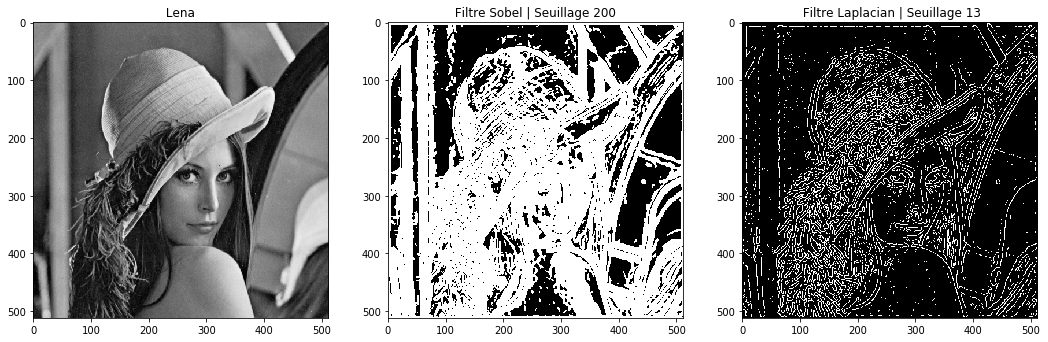

In [24]:
affichages = [ lena, SobelDetector( Ig, 200 ), LaplacianDetector( Ig, 13 ) ]
niceDisplay14( affichages, [ " Lena ", " Image avec filtre Sobel | Seuillage 200 ", " Image avec filtre Laplacian | Seuillage 13" ] )


* <font color="red"> Avec un filtre Sobel, on observe moins les détails de l'image et les contours semblent épaix </font>
* <font color="red"> Avec un filtre Laplacian, on observe une réduction du bruit sur l'image grâce au filtre gaussien appliqué </font>
* <font color="red"> Après lissage, la différence principale entre ces deux détecteurs réside dans le fait que le filtre Laplacian est plus sensible au bruit car c'est un filtre de second ordre </font>


3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

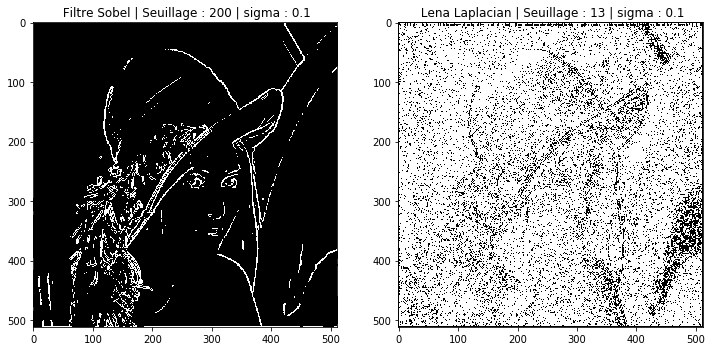

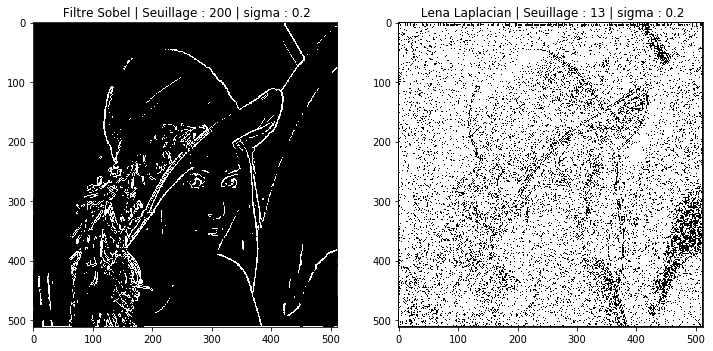

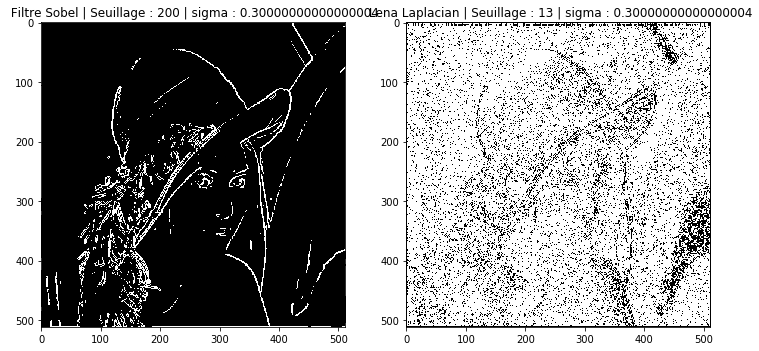

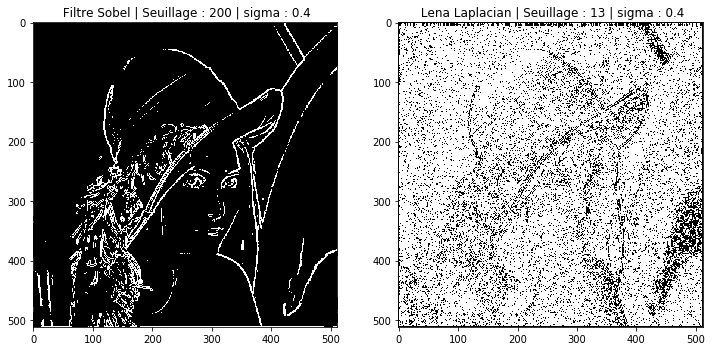

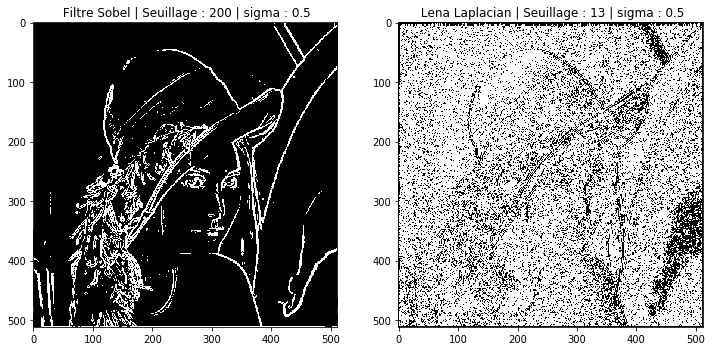

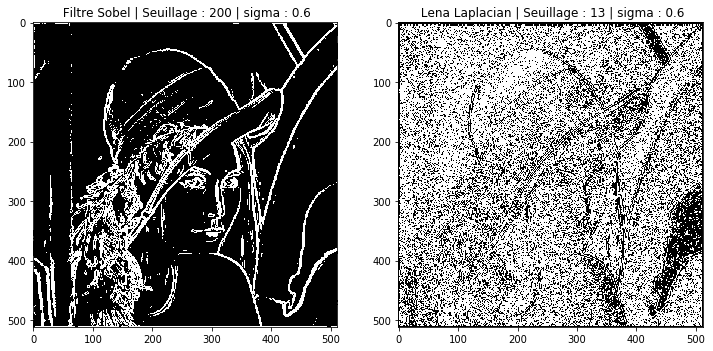

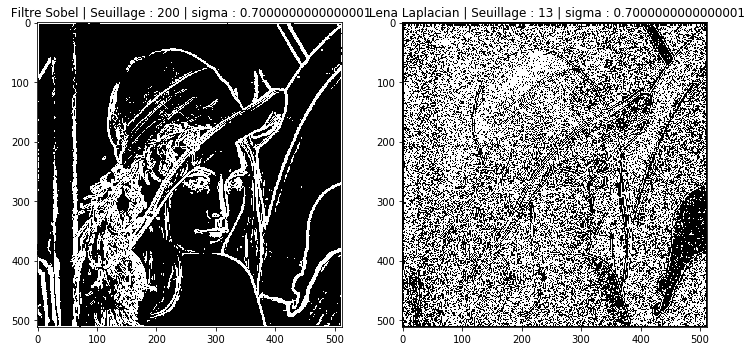

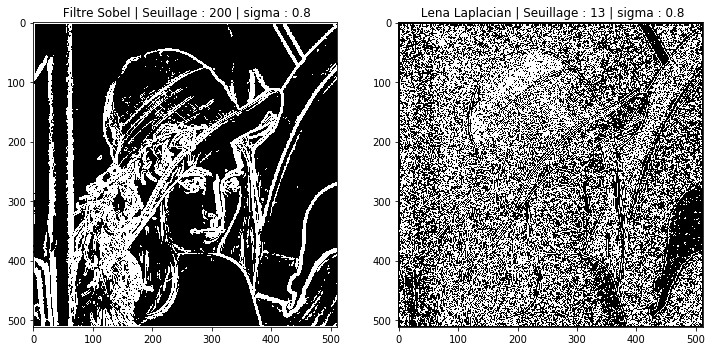

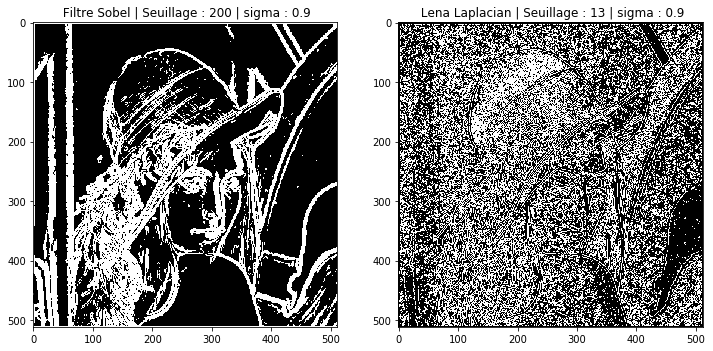

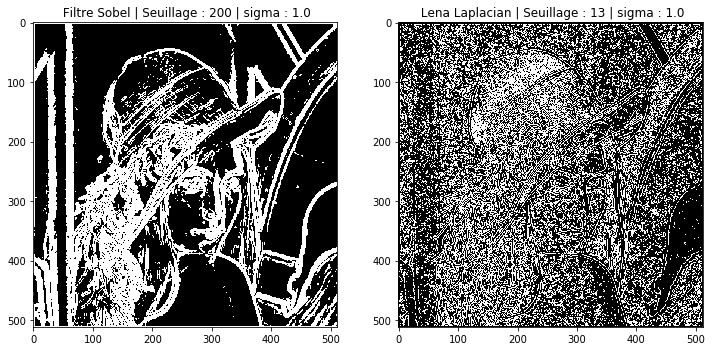

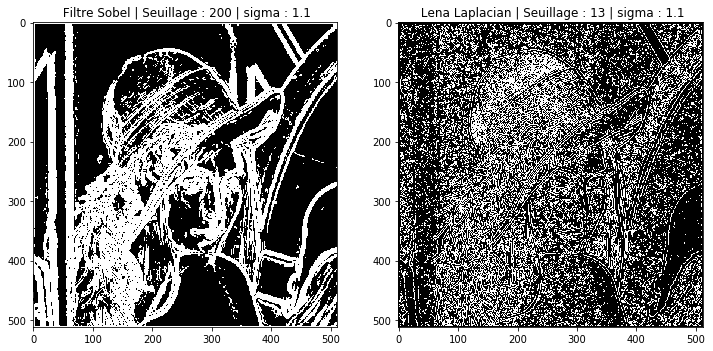

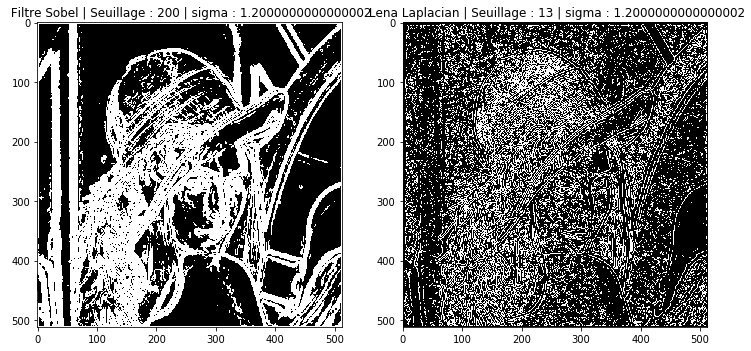

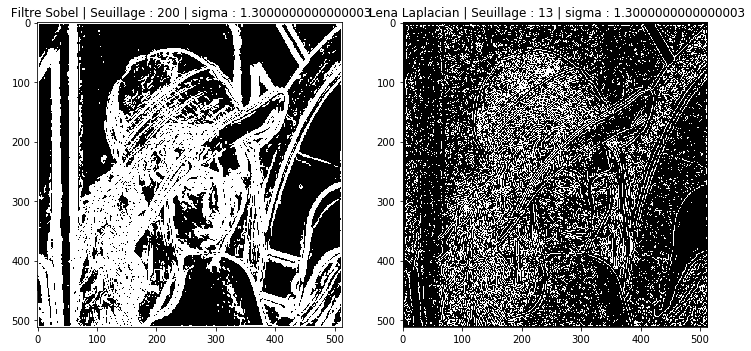

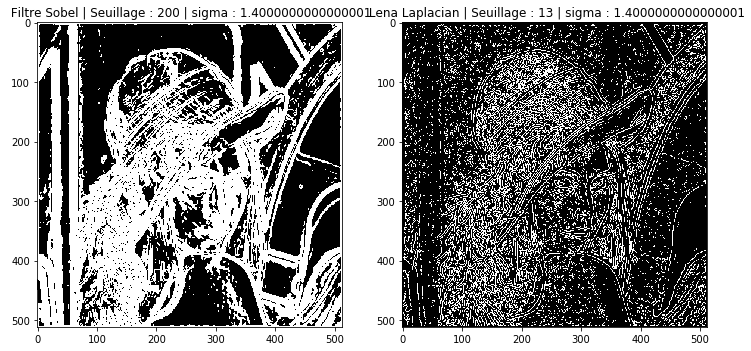

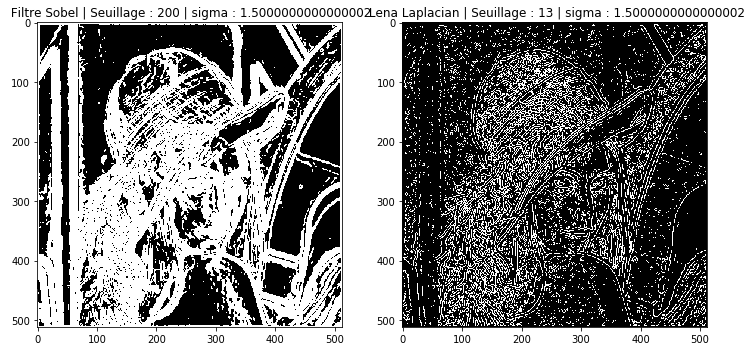

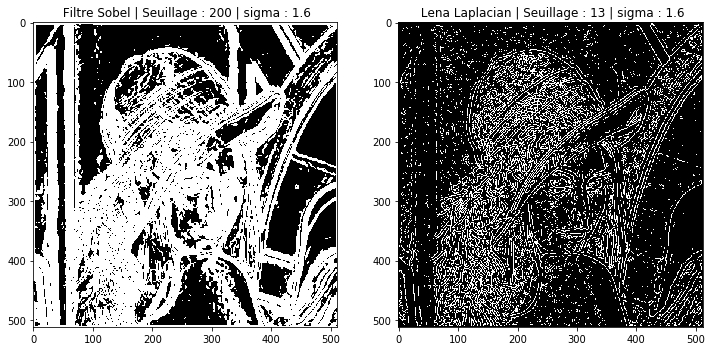

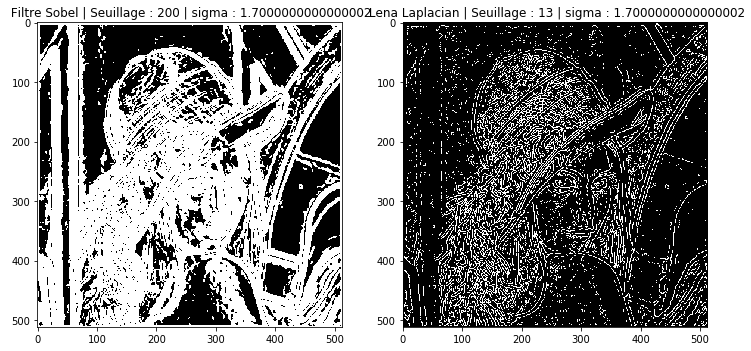

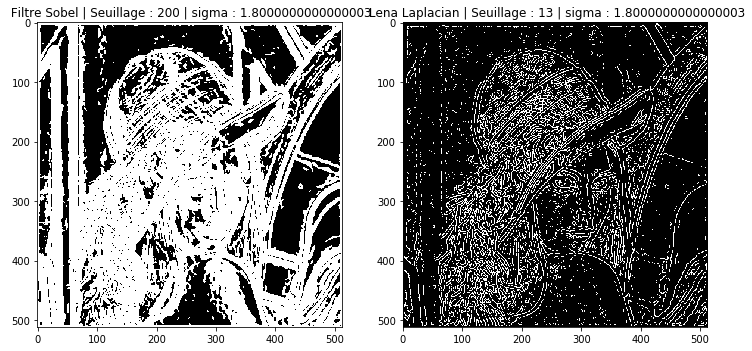

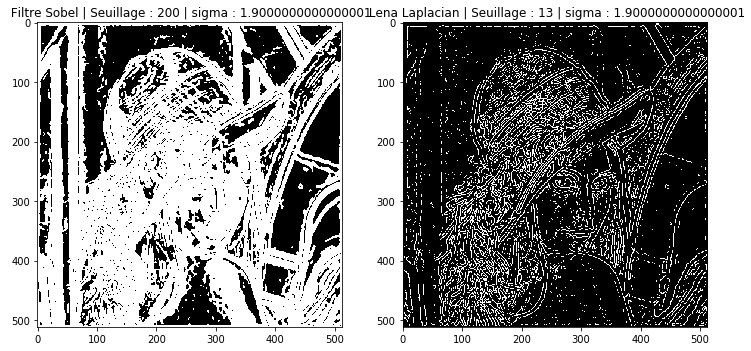

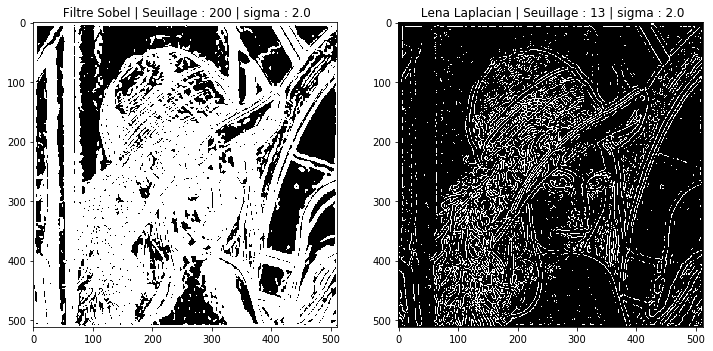

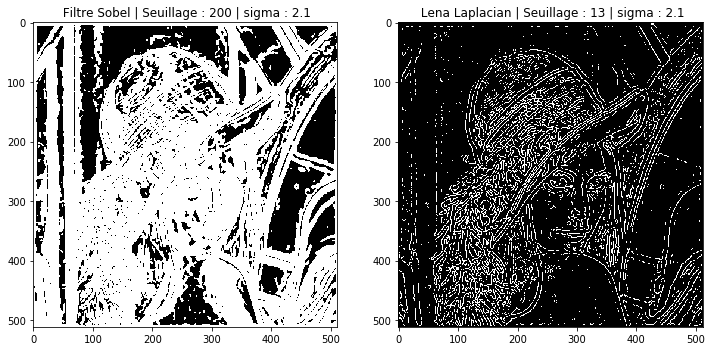

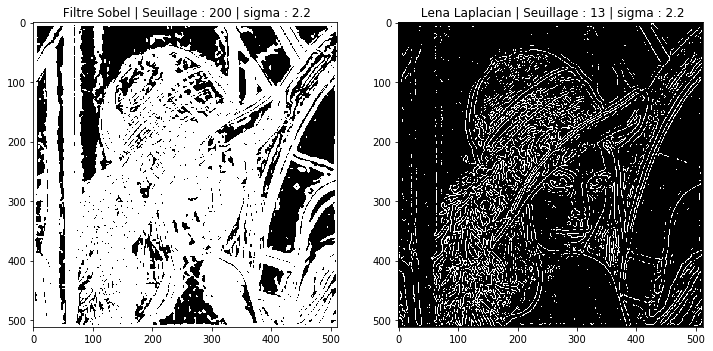

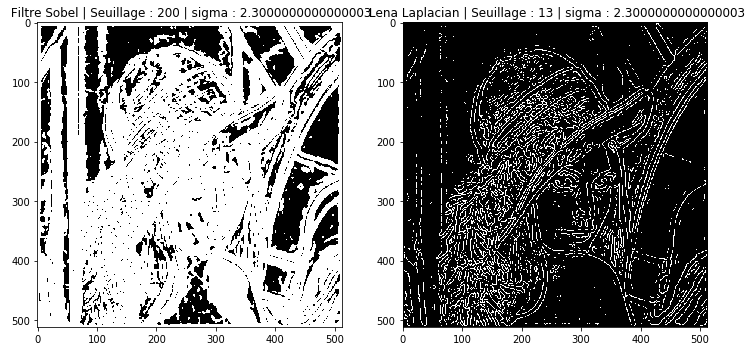

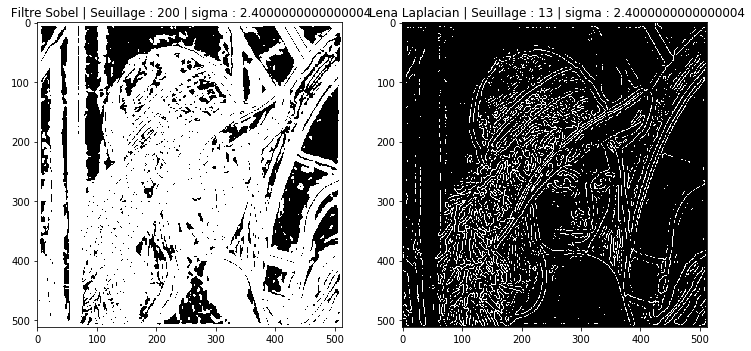

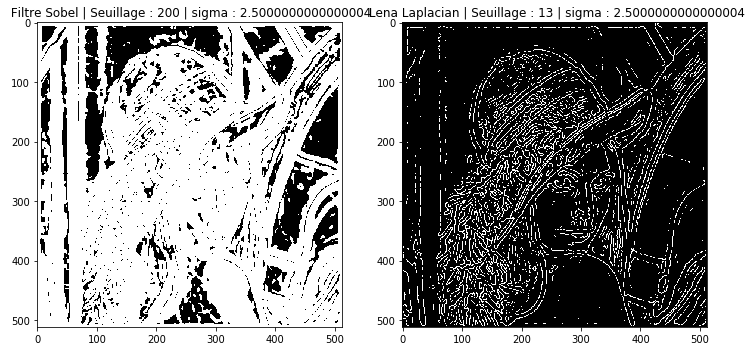

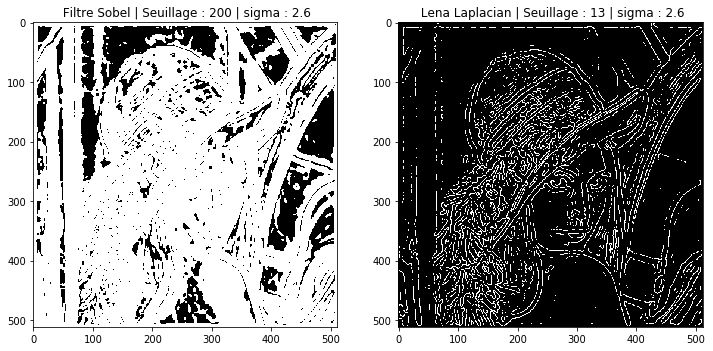

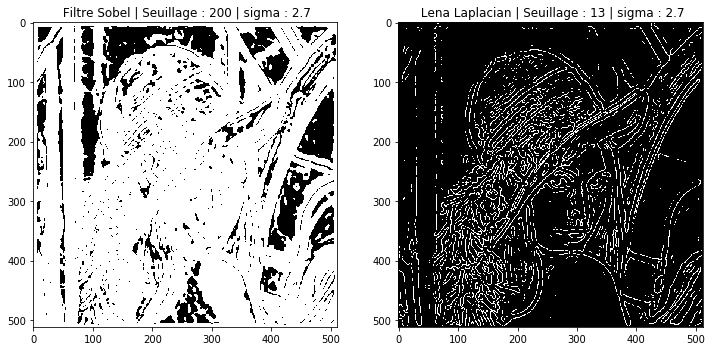

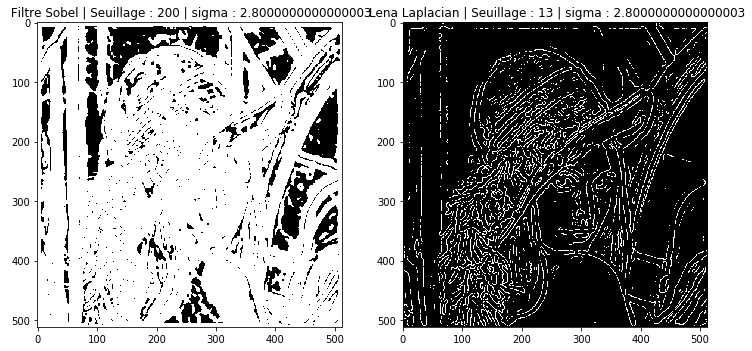

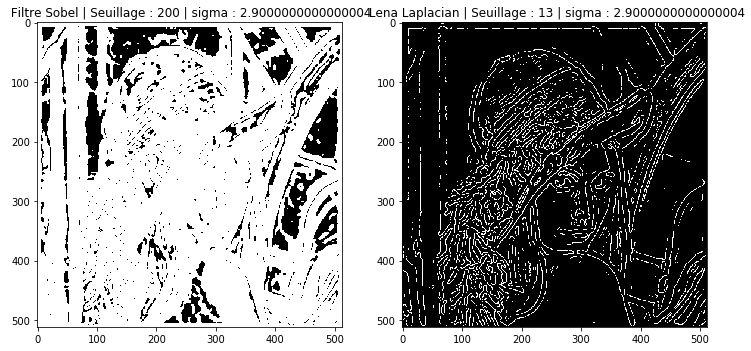

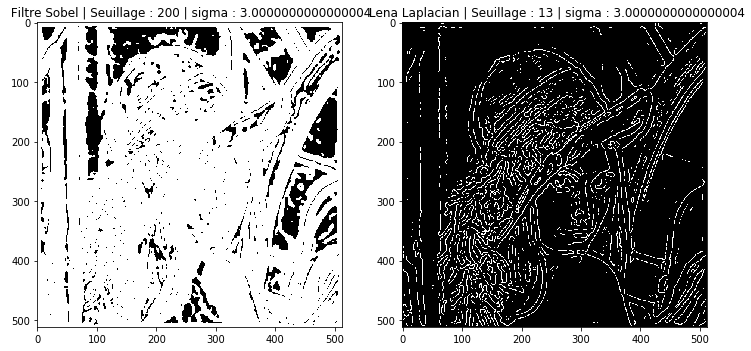

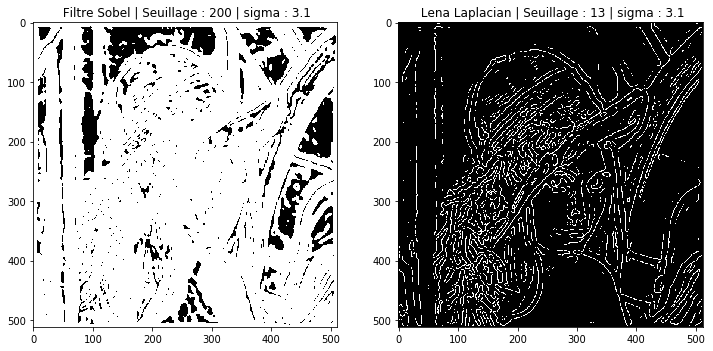

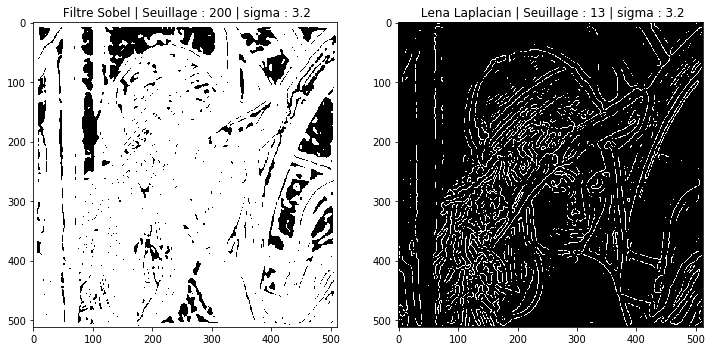

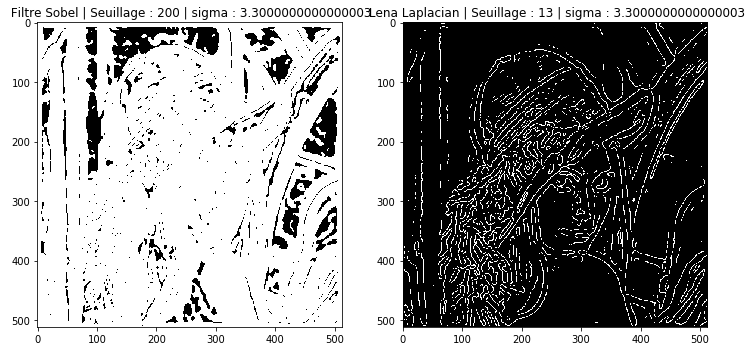

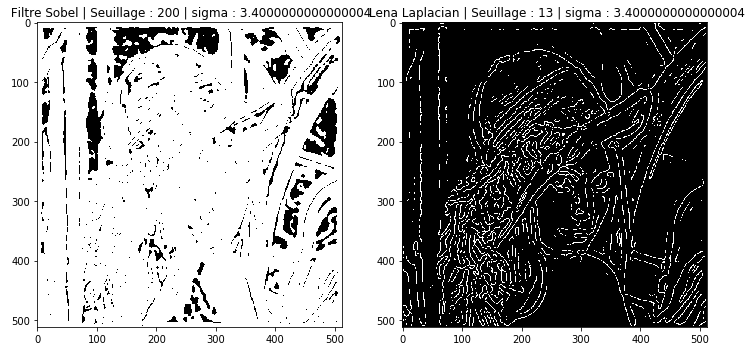

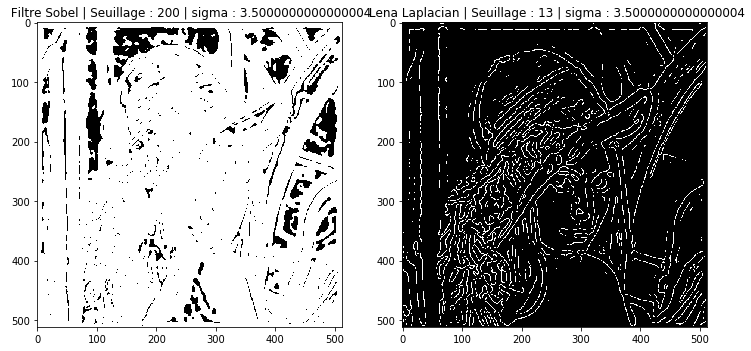

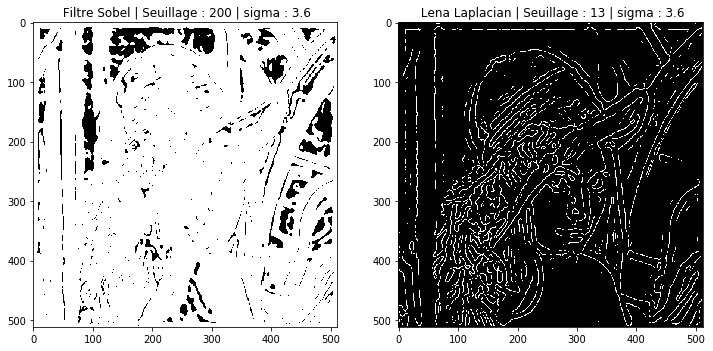

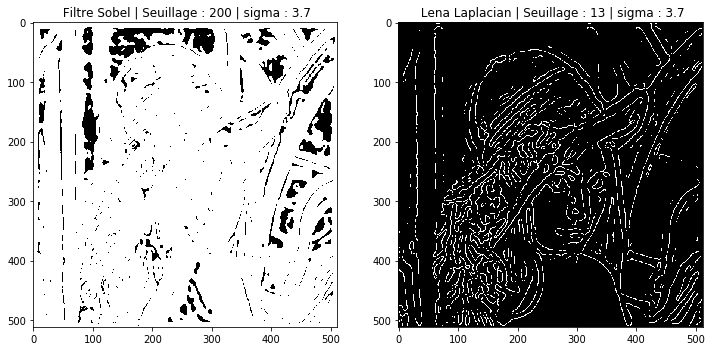

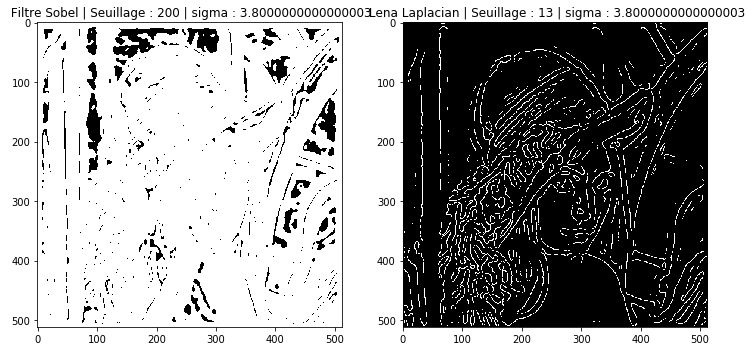

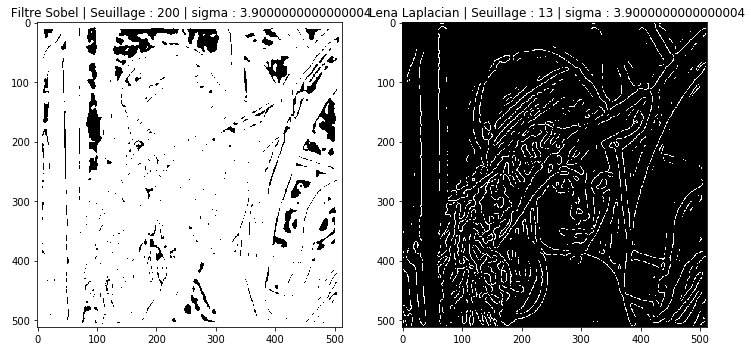

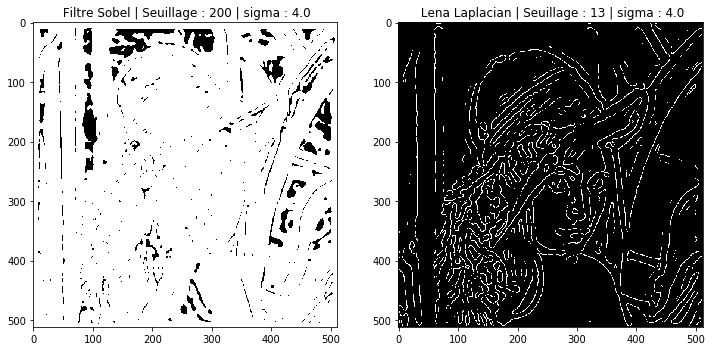

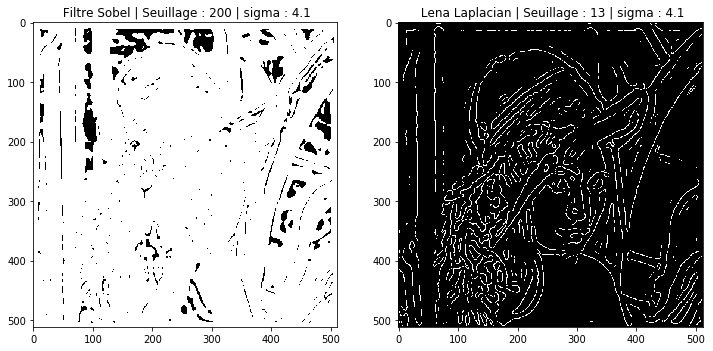

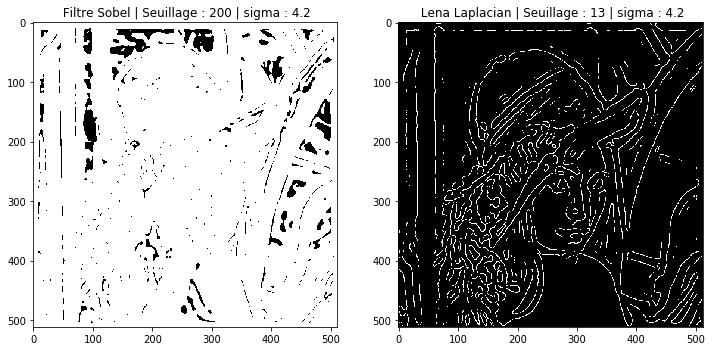

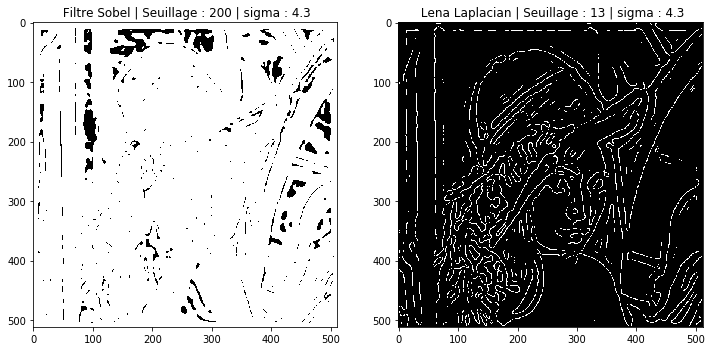

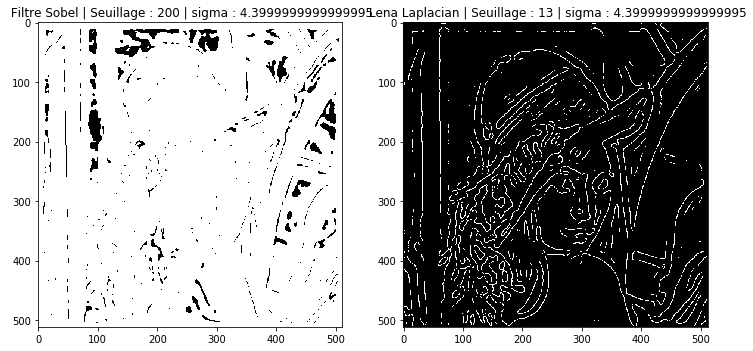

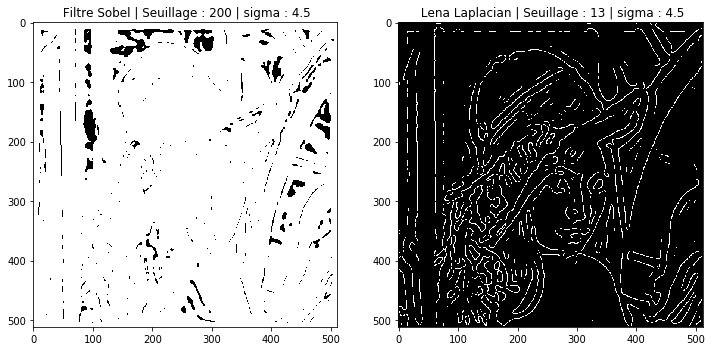

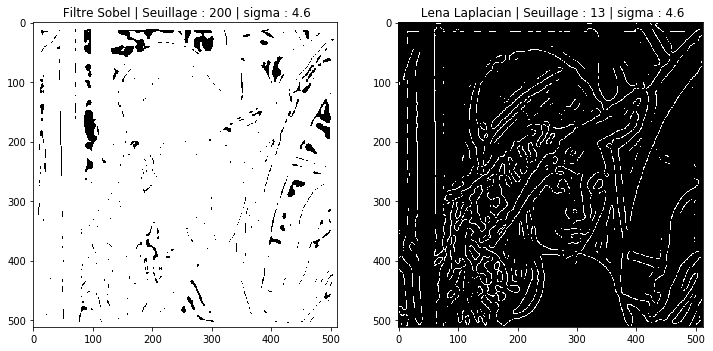

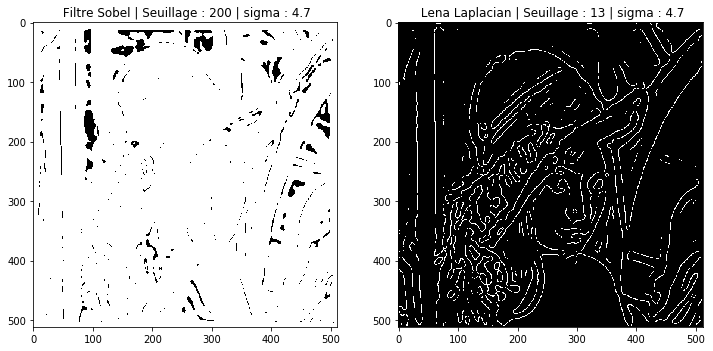

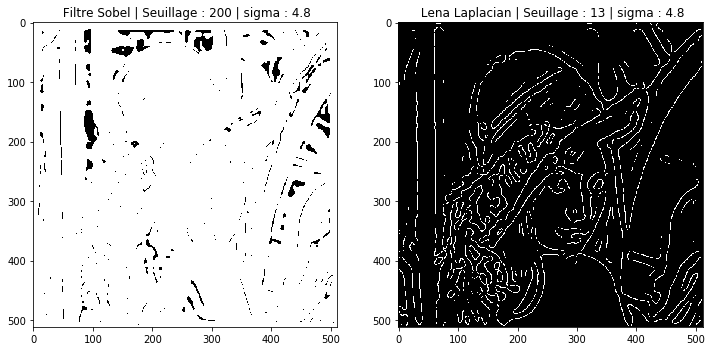

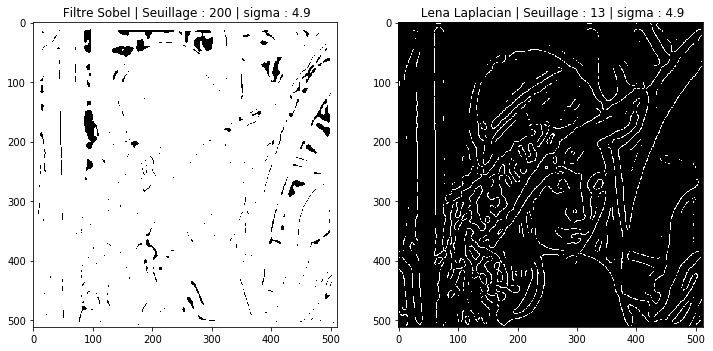

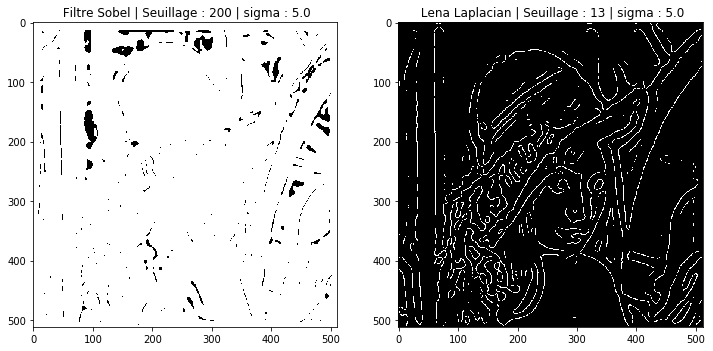

In [26]:
# Test différents sigma

for i in np.arange(0.1,5.1,0.1):
    G = gaussianKernel(i)
    Ig = convolve2d( lena, G, 'same' )
    S = SobelDetector( Ig, 200 ) 
    L = LaplacianDetector( Ig, 13 )
    niceDisplay14( [ S, L ], [ " Image avec filtre Sobel | Seuillage : 200 | sigma : "+str(i), " Image avec filtre Laplacian | Seuillage : 13 | sigma : "+str(i) ] )
    

<font color="red"> Analyse des résultats concernant les deux détecteurs : </font>

* <font color="red"> Pour le Sobel, lorsque $\sigma <=$ 0.7 alors les contours détectés sont plus fins, au-delà ($\sigma >$ 0.7) on en perd les détails </font> 
* <font color="red"> Pour le Laplacian, lorsque $\sigma <=$ 2.0 alors on observe du bruit sur l'image montrant que le lissage ne fait pas encore effet, au-delà ($\sigma >$ 2.0) l'image devient plus nette, sans bruit et on distingue les contours </font>

<font color="red"> Ainsi les effets du lissage permettent d'atténuer les hautes fréquences et donc de retirer du bruit sur l'image mais également de rendre l'apparition des contours plus fins. </font>

<font color="red"> Plus sigma est grand plus le lissage est important </font>

4. Replace the gaussian filter by a constrast enhancer filter. Discuss the results

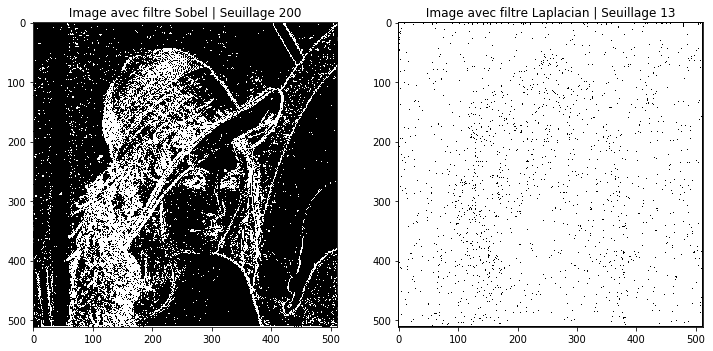

In [18]:
# Filtre réhausseur de contraste
C = np.array( [ [ 1, -3, 1 ], [ -3, 9, -3], [1, -3, 1] ])

# Convolution : lena * C
Ic = convolve2d( lena, C, 'same' )

affichages = [ SobelDetector( Ic, 200 ), LaplacianDetector( Ic, 13 ) ]
niceDisplay14( affichages, [ " Image avec filtre Sobel | Seuillage 200 ", " Image avec filtre Laplacian | Seuillage 13 " ] )


 <font color="red"> Interprétations des résultats :</font>
 
* <font color="red"> Pour le filtre Sobel, lorsqu'on remplace le filtre gaussien par un réhausseur de contraste en gardant le même niveau de seuillage, on observe mieux les contours et les détails de l'image mais on observe également l'apparition du bruit sur l'image </font>
* <font color="red"> Pour le filtre Laplacian, lorsqu'on remplace le filtre gaussien par un réhausseur de contraste en gardant le même niveau de seuillage, on ne distingue plus du tout les contours par rapport à un filtre gaussien et on remarque qu'en augmentant le seuillage, on arrive à percevoir des contours sauf que beaucoup de bruits entourent l'image </font>

<font color="red"> Ainsi un filtre réhausseur de contraste a pour effet de faire passer les hautes fréquences d'où le fait de voir apparaitre du bruit sur nos deux images car ici on a appliqué successivement deux filtres passe-haut ( filtre réhausseur de contraste puis filtre Sobel | Laplacian ) </font>

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

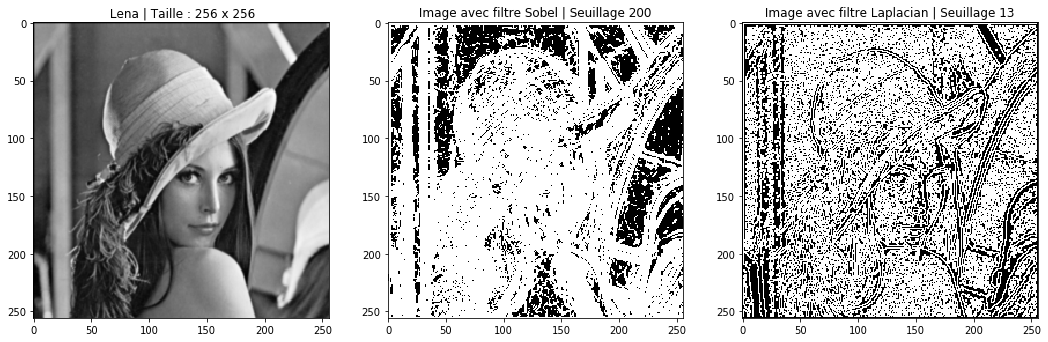

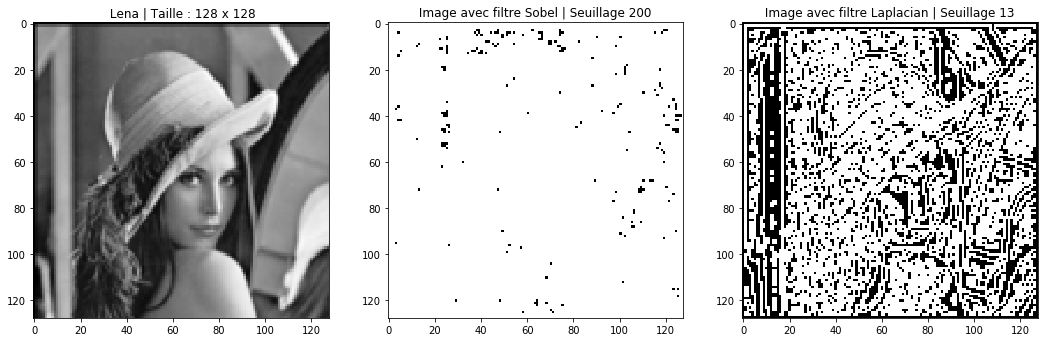

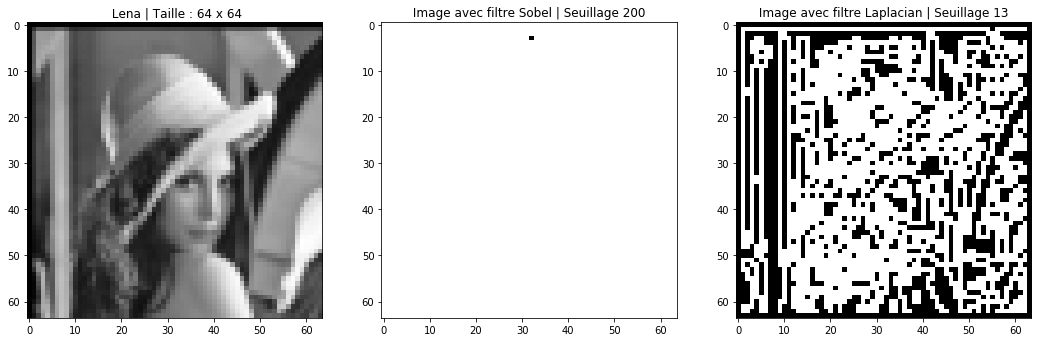

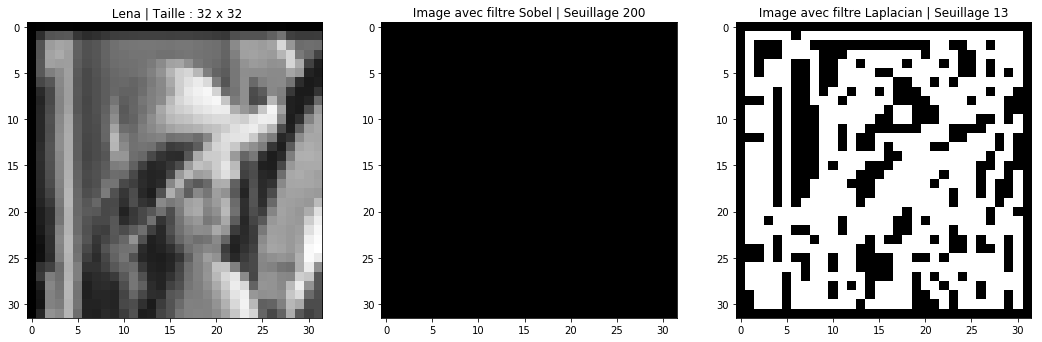

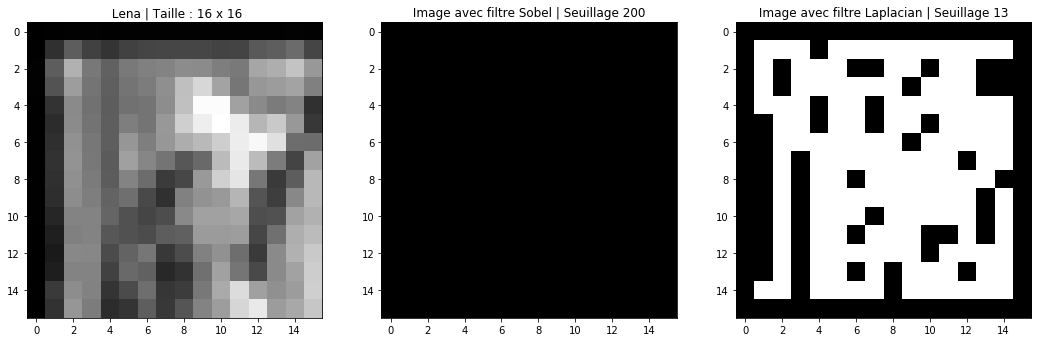

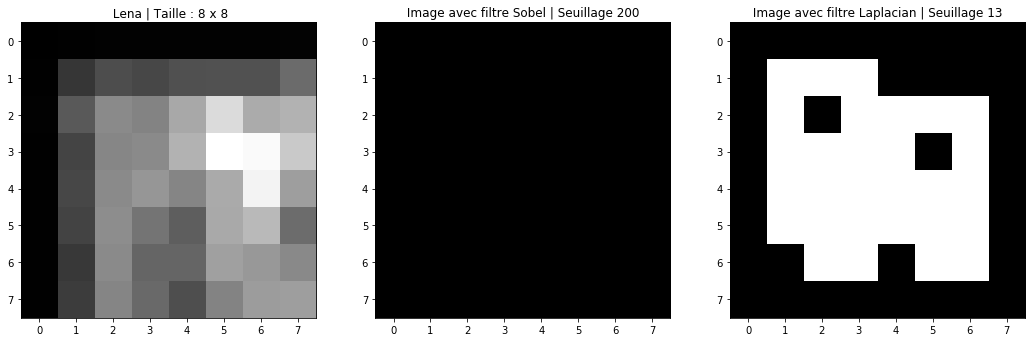

In [28]:
# Masque gaussien
G = gaussianKernel(0.8)

# Convolution : lena * G
Ig = convolve2d( lena, G, 'same' )

while len(Ig) > 8:
    #Ik : Ik+1 = (Ik * gσ)↓2 
    Ig = subSample2(convolve2d( Ig, G, 'same' ))
    affichages = [Ig, SobelDetector( Ig, 200 ), LaplacianDetector( Ig, 13 ) ]
    niceDisplay14( affichages, [" Lena | Taille : "+str(len(Ig))+" x "+str(len(Ig)), " Image avec filtre Sobel | Seuillage 200 ", " Image avec filtre Laplacian | Seuillage 13 " ])


* <font color="red"> A chaque itération du sous-échantillonnage, l'image devient plus petite avec un lissage plus important mais en diminuant la résolution de l'image </font>
* <font color="red"> On observe du bruit qui apparait au niveau des contours à chaque itération (notamment à partir d'une image taile 64x64) </font>
* <font color="red"> On observe ainsi les effets du lissage sur différentes résolutions et notamment à l'apparition d'un effet escalier sur les contours </font>